In [1]:
from exp import *

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
dm = DatasetManager('2017',224,'all','2017')

In [4]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=0.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=224)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

# Adding attention

### Imports

In [5]:
import geffnet
from geffnet.efficientnet_builder import *

import types

In [6]:
DepthwiseSeparableConv and InvertedResidual and True

True

Hay que ponerle arl en inverted residuals y a depthwiseseparableconvs

## Normal forward funcs

In [7]:
def depthwise_separable_conv_forward(self, x):
        residual = x

        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.se(x)

        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.act2(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x += residual
        return x

In [8]:
def ir_forward(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
        x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x += residual
        return x

# EfficientNet baseline 

In [9]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)
random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph])

learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.087503,0.637578,0.293333,0.706667,0.653333,00:06
1,0.918617,0.798605,0.360000,0.640000,0.606667,00:07


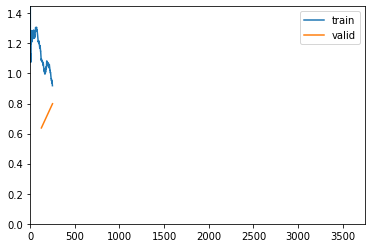

Process Process-1106:
Process Process-1115:
Process Process-1117:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff04eed8ef0>
Traceback (most recent call last):
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
Process Process-1119:
Traceback (most recent call last):
Traceback (most recent call last):
Tracebac

KeyboardInterrupt: 

  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/util.py", line 299, in _exit_function
    _run_finalizers(0)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/util.py", line 299, in _exit_function
    _run_finalizers(0)
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 197, in _worker_loop
    if 

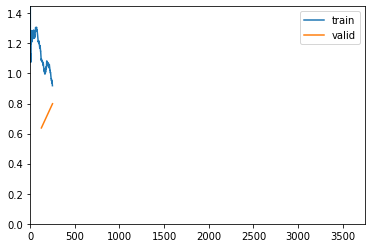

In [55]:
random_seed(1,True)
learn.fit_one_cycle(30, max_lr=slice(3e-03))

# EfficientNet Without Squeeze and Exite

In [10]:
alpha_initial_value = 0.001
def ir_forward_without_se(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
#         x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual
        return x


def remove_se(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Override forward func
    a_module.forward = types.MethodType(ir_forward_without_se,a_module)

def remove_se_from_model(m):
    apply_leaf(m, remove_se)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.986143,0.817509,0.240000,0.760000,0.587222,00:05
1,0.783036,0.757923,0.246667,0.753333,0.565556,00:05
2,0.597698,1.090975,0.300000,0.700000,0.408472,00:05
3,0.548487,0.624762,0.186667,0.813333,0.645000,00:05
4,0.540267,0.545202,0.186667,0.813333,0.721667,00:05
5,0.450094,0.502642,0.173333,0.826667,0.746944,00:05
6,0.469598,0.532136,0.226667,0.773333,0.720833,00:05
7,0.430224,0.527832,0.186667,0.813333,0.691389,00:05
8,0.437012,0.470321,0.180000,0.820000,0.758056,00:05
9,0.416746,0.452018,0.180000,0.820000,0.768611,00:05


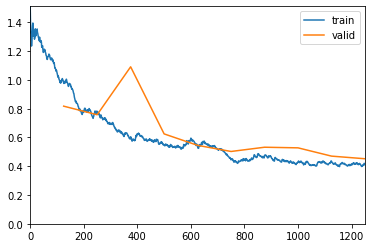

In [575]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

remove_se_from_model(model)

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph])

learn.unfreeze()

random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

# EfficientNet Without Squeeze and Exite and with ARL

In [11]:
alpha_initial_value = 0.001
def attn_ir_forward_without_se(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
#         x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual + (residual 
                     * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) 
                     * self.alpha)
        return x


def change_inverted_residual_blocks_without_se(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Add params
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
#     Override forward func
    a_module.forward = types.MethodType(attn_ir_forward_without_se,a_module)


def add_attn_geffnet_efficientnet_without_se(m):
    apply_leaf(m, change_inverted_residual_blocks_without_se)

In [12]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [13]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

add_attn_geffnet_efficientnet_without_se(model)
attn_blocks = [block for block in model.modules() if isinstance(block,InvertedResidual)]

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph,
                                     partial(Alphas, modules=attn_blocks)
                                     ])

learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.981419,0.770583,0.253333,0.746667,0.575556,00:05
1,0.784706,0.652252,0.206667,0.793333,0.586111,00:06
2,0.617962,0.887215,0.260000,0.740000,0.474722,00:06
3,0.574790,0.657037,0.253333,0.746667,0.665833,00:05
4,0.477176,0.513291,0.200000,0.800000,0.731389,00:06
5,0.450125,0.448872,0.173333,0.826667,0.766111,00:05
6,0.441273,0.493964,0.206667,0.793333,0.752778,00:06
7,0.427240,0.473675,0.206667,0.793333,0.777222,00:05
8,0.427300,0.435875,0.186667,0.813333,0.790833,00:05
9,0.412783,0.432338,0.180000,0.820000,0.795556,00:05


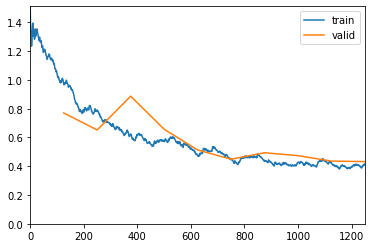

In [570]:
random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

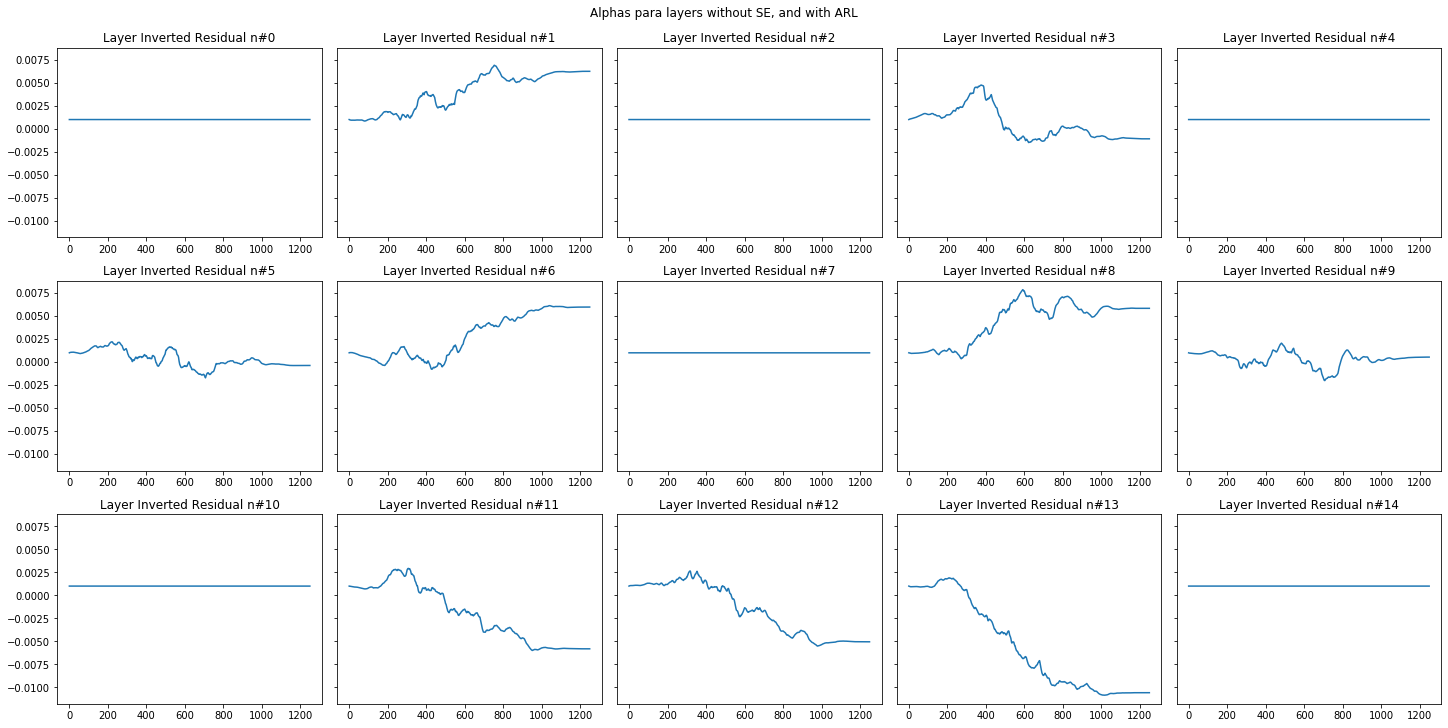

In [571]:
fig,axs = plt.subplots(3,5,figsize=(20,10), constrained_layout=True, sharey=True)

fig.suptitle('Alphas para layers without SE, and with ARL')

for i in range(15):
    axs[i//5][i%5].set_title(f"Layer Inverted Residual n#{i}")
    axs[i//5][i%5].plot(learn.alphas.stats[0][i])
    

# Efficientnet With Squeeze and Exite and With ARL

## Modify model

In [14]:
# alpha_initial_value = 0.001

# def attn_depthwise_separable_conv_forward(self, x):
#         residual = x

#         x = self.conv_dw(x)
#         x = self.bn1(x)
#         x = self.act1(x)

#         x = self.se(x)

#         x = self.conv_pw(x)
#         x = self.bn2(x)
#         x = self.act2(x)

#         if self.has_residual:
#             if self.drop_connect_rate > 0.:
#                 x = drop_connect(x, self.training, self.drop_connect_rate)
# #                 Aca no se entra nunca pues hay un solo bloque depthwise que no tiene residual
#             print('asd', self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x).shape)
#             x = x + residual + (residual * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) * self.alpha)
        
#         return x


# def change_depthwise_separable_blocks(a_module):
#     if not isinstance(a_module,DepthwiseSeparableConv): return
    
# #     Add params
#     a_module.softmaxLayer = nn.Softmax(2);
#     a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
# #     Override forward func
#     a_module.forward = types.MethodType(attn_depthwise_separable_conv_forward,a_module)


In [15]:
alpha_initial_value = 0.001
def attn_ir_forward(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
        x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual + (residual 
                     * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) 
                     * self.alpha)
        return x


def change_inverted_residual_blocks(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Add params
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
#     Override forward func
    a_module.forward = types.MethodType(attn_ir_forward,a_module)


In [16]:
def add_attn_geffnet_efficientnet(m):
#     apply_leaf(m, change_depthwise_separable_blocks)
    apply_leaf(m, change_inverted_residual_blocks)

In [17]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [18]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

add_attn_geffnet_efficientnet(model)
attn_blocks = [block for block in model.modules() if isinstance(block,InvertedResidual)]

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph,
                                     partial(Alphas, modules=attn_blocks)
                                     ])

learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.078955,0.677547,0.360000,0.640000,0.662778,00:07
1,0.839798,0.588233,0.246667,0.753333,0.687778,00:07
2,0.596223,0.584759,0.193333,0.806667,0.586389,00:07
3,0.469554,0.517532,0.206667,0.793333,0.699167,00:07
4,0.442409,0.596164,0.213333,0.786667,0.707222,00:07
5,0.405900,0.462493,0.166667,0.833333,0.762222,00:07
6,0.416873,0.404152,0.186667,0.813333,0.841667,00:07
7,0.373077,0.432188,0.173333,0.826667,0.811944,00:07
8,0.363574,0.447403,0.180000,0.820000,0.812222,00:07
9,0.340511,0.411641,0.173333,0.826667,0.831389,00:07


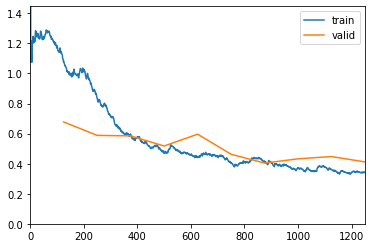

In [553]:
random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

AttributeError: 'Learner' object has no attribute 'alphas'

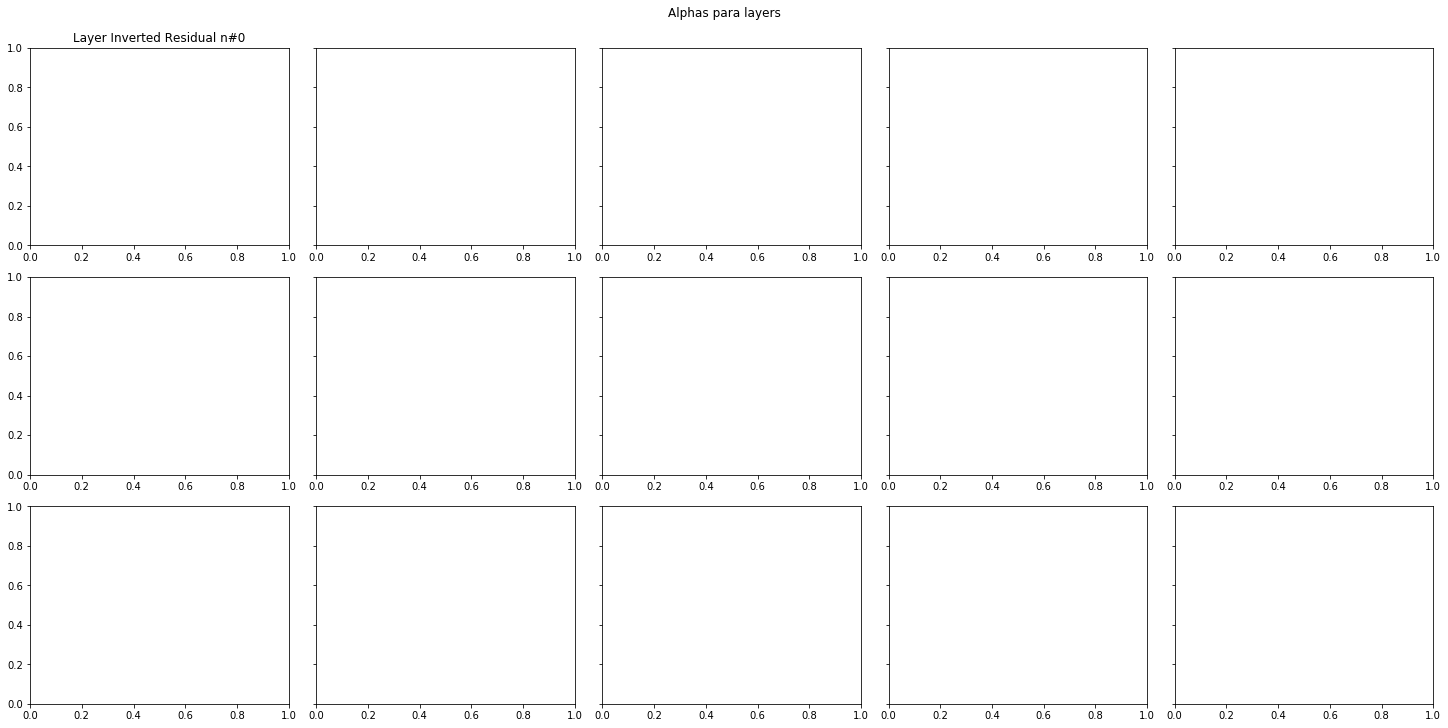

In [19]:
fig,axs = plt.subplots(3,5,figsize=(20,10), constrained_layout=True, sharey=True)

fig.suptitle('Alphas para layers')

for i in range(15):
    axs[i//5][i%5].set_title(f"Layer Inverted Residual n#{i}")
    axs[i//5][i%5].plot(learn.alphas.stats[0][i])
    

# Comparison for various seeds

In [26]:
def train_variant(seed, epochs,transformation):
    data = reload_dataset(dm,seed)    
    
    model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)    
    transformation(model)
    
    random_seed(seed,True)
    learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                            callback_fns=[ShowGraph, OverSamplingCallback])

    learn.unfreeze()
    learn.fit_one_cycle(epochs, max_lr=slice(3e-03))
    return learn.recorder.metrics

In [27]:
columns = ['Baseline','Without SE', "Without SE and with ARL", "With Both"]
','.join(columns) + '\n'

'Baseline,Without SE,Without SE and with ARL,With Both\n'

In [30]:
results_file_name = 'results/efficientnet_attention_analysis_run_seed'
columns = ['Baseline','Without SE', "Without SE and with ARL", "With Both"]
def write_results(seed, m1,m2,m3,m4):
    l1 = list(map(lambda x: x[1], m1))
    l2 = list(map(lambda x: x[1], m2))
    l3 = list(map(lambda x: x[1], m3))
    l4 = list(map(lambda x: x[1], m4))
    


    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()},{c.item()},{d.item()}\n' for a,b,c,d in zip(l1,l2,l3,l4) ]))
    f.write(run)
    f.close()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.054290,0.598680,0.273333,0.726667,0.681389,00:16
1,0.890195,0.550616,0.213333,0.786667,0.755278,00:16
2,0.785975,0.581822,0.220000,0.780000,0.744444,00:16
3,0.613673,0.428830,0.180000,0.820000,0.815000,00:16
4,0.497063,0.519514,0.186667,0.813333,0.795000,00:16
5,0.466207,0.465060,0.166667,0.833333,0.816111,00:16
6,0.432036,0.484223,0.193333,0.806667,0.826111,00:16
7,0.469821,0.400236,0.153333,0.846667,0.871389,00:16
8,0.375163,0.453006,0.173333,0.826667,0.814167,00:16
9,0.335986,0.411023,0.193333,0.806667,0.860278,00:16


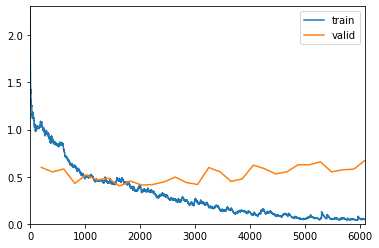

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.027485,1.227163,0.406667,0.593333,0.392222,00:13
1,0.843950,0.744946,0.220000,0.780000,0.699444,00:13
2,0.845326,0.745535,0.226667,0.773333,0.568889,00:13
3,0.712034,0.663206,0.266667,0.733333,0.515278,00:13
4,0.608429,0.445035,0.193333,0.806667,0.758889,00:13
5,0.592768,0.429297,0.166667,0.833333,0.775555,00:13
6,0.585797,0.546203,0.280000,0.720000,0.715278,00:13
7,0.542431,0.515427,0.193333,0.806667,0.738889,00:13
8,0.540507,0.580118,0.233333,0.766667,0.657222,00:13
9,0.530488,0.471128,0.193333,0.806667,0.723611,00:13


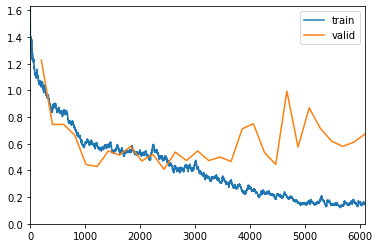

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.020485,1.189818,0.420000,0.580000,0.399167,00:13
1,0.840508,0.769107,0.206667,0.793333,0.678611,00:13
2,0.832752,0.796470,0.220000,0.780000,0.576944,00:13
3,0.691637,0.731353,0.260000,0.740000,0.496667,00:13
4,0.622521,0.462793,0.200000,0.800000,0.747778,00:13
5,0.618162,0.444000,0.180000,0.820000,0.788611,00:13
6,0.536101,0.363083,0.173333,0.826667,0.860556,00:13
7,0.586642,0.457571,0.180000,0.820000,0.769444,00:13
8,0.588849,0.448578,0.213333,0.786667,0.762778,00:13
9,0.558846,0.435693,0.160000,0.840000,0.776389,00:13


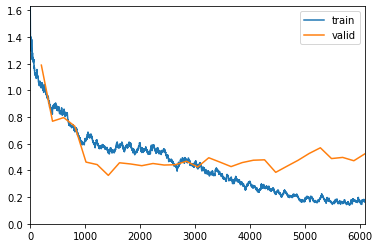

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.053352,0.596143,0.273333,0.726667,0.681111,00:16
1,0.896824,0.542455,0.180000,0.820000,0.766945,00:17
2,0.773268,0.565475,0.193333,0.806667,0.746667,00:17
3,0.606344,0.447754,0.206667,0.793333,0.790556,00:17
4,0.487739,0.458901,0.186667,0.813333,0.813611,00:16
5,0.474524,0.513763,0.166667,0.833333,0.756111,00:17
6,0.427485,0.565813,0.213333,0.786667,0.769722,00:17
7,0.425309,0.377029,0.133333,0.866667,0.883611,00:17
8,0.397697,0.399656,0.153333,0.846667,0.858611,00:17
9,0.352254,0.447195,0.193333,0.806667,0.844722,00:17


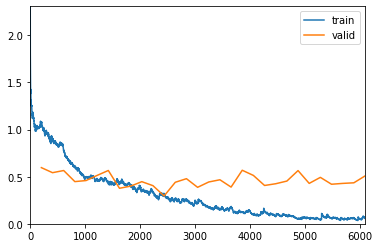

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.019422,0.521667,0.206667,0.793333,0.729722,00:16
1,0.896280,0.716059,0.200000,0.800000,0.689722,00:16
2,0.728293,0.530519,0.193333,0.806667,0.743056,00:16
3,0.559801,0.519971,0.220000,0.780000,0.770000,00:16
4,0.482695,0.488455,0.186667,0.813333,0.791389,00:16
5,0.506205,0.548288,0.293333,0.706667,0.775278,00:16
6,0.420455,0.559524,0.226667,0.773333,0.744722,00:16
7,0.460046,0.511598,0.246667,0.753333,0.769444,00:16
8,0.406070,0.659457,0.286667,0.713333,0.615556,00:16
9,0.349404,0.493636,0.173333,0.826667,0.861944,00:16


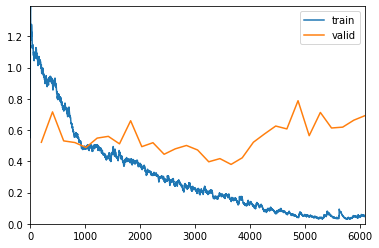

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.025722,0.752190,0.266667,0.733333,0.502500,00:13
1,0.828783,0.711774,0.246667,0.753333,0.519444,00:13
2,0.769937,0.580328,0.200000,0.800000,0.598333,00:13
3,0.696898,0.513798,0.186667,0.813333,0.642778,00:13
4,0.614729,0.583408,0.200000,0.800000,0.575833,00:13
5,0.595729,0.586981,0.313333,0.686667,0.697500,00:13
6,0.574641,0.432740,0.193333,0.806667,0.768056,00:13
7,0.587188,0.455696,0.193333,0.806667,0.796389,00:13
8,0.559255,0.564569,0.300000,0.700000,0.680000,00:13
9,0.560368,0.514577,0.186667,0.813333,0.800000,00:13


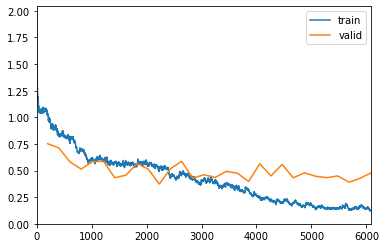

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.029944,0.763802,0.300000,0.700000,0.506389,00:13
1,0.836010,0.756016,0.233333,0.766667,0.528611,00:13
2,0.785296,0.699550,0.266667,0.733333,0.481667,00:13
3,0.702330,0.586494,0.293333,0.706667,0.620278,00:13
4,0.598393,0.493616,0.220000,0.780000,0.718056,00:13
5,0.609550,0.572514,0.300000,0.700000,0.712222,00:13
6,0.593298,0.487496,0.186667,0.813333,0.752778,00:13
7,0.578151,0.483768,0.220000,0.780000,0.756111,00:13
8,0.566475,0.637382,0.213333,0.786667,0.696944,00:13
9,0.494097,0.483966,0.186667,0.813333,0.786111,00:13


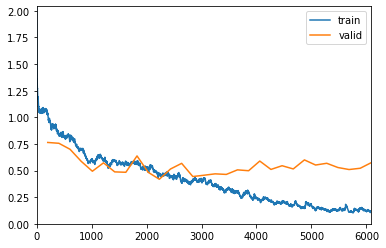

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.018507,0.522118,0.200000,0.800000,0.730278,00:17
1,0.897663,0.708718,0.200000,0.800000,0.692778,00:16
2,0.726851,0.534341,0.166667,0.833333,0.745833,00:17
3,0.547120,0.523996,0.193333,0.806667,0.780278,00:17
4,0.485476,0.451191,0.193333,0.806667,0.801667,00:17
5,0.501050,0.344237,0.113333,0.886667,0.864722,00:17
6,0.436219,0.453696,0.173333,0.826667,0.792778,00:17
7,0.448008,0.416755,0.193333,0.806667,0.811389,00:17
8,0.393125,0.363544,0.173333,0.826667,0.861111,00:17
9,0.337828,0.481401,0.153333,0.846667,0.827222,00:17


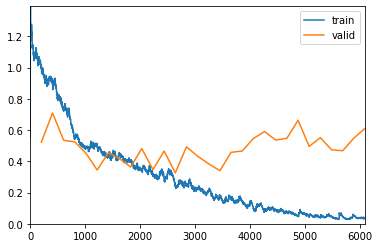

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.998055,0.614437,0.266667,0.733333,0.724167,00:16
1,0.922760,0.540667,0.166667,0.833333,0.782222,00:16
2,0.810953,0.514285,0.180000,0.820000,0.785556,00:16
3,0.586890,0.536678,0.186667,0.813333,0.720278,00:16
4,0.495651,0.481179,0.213333,0.786667,0.776111,00:16
5,0.470833,0.385861,0.160000,0.840000,0.848611,00:16
6,0.420457,0.433652,0.180000,0.820000,0.833056,00:16
7,0.411592,0.439250,0.140000,0.860000,0.852222,00:16
8,0.390135,0.437902,0.133333,0.866667,0.823611,00:16
9,0.355696,0.413953,0.186667,0.813333,0.854444,00:16


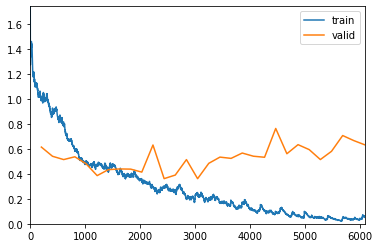

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.970522,0.577164,0.193333,0.806667,0.748333,00:13
1,0.921905,0.485640,0.186667,0.813333,0.771389,00:13
2,0.794024,0.662854,0.206667,0.793333,0.621944,00:13
3,0.690739,0.540022,0.220000,0.780000,0.692778,00:13
4,0.652766,0.530377,0.180000,0.820000,0.741944,00:13
5,0.557609,0.582308,0.206667,0.793333,0.710556,00:13
6,0.558350,0.445521,0.186667,0.813333,0.762222,00:13
7,0.560044,0.562777,0.186667,0.813333,0.793056,00:13
8,0.534137,0.488147,0.186667,0.813333,0.774167,00:13
9,0.585248,0.406852,0.173333,0.826667,0.830000,00:13


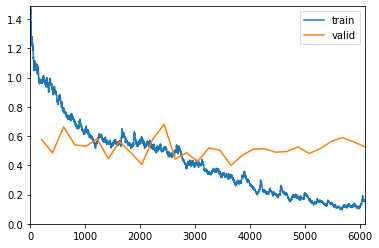

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.971788,0.573896,0.186667,0.813333,0.761389,00:13
1,0.940943,0.492796,0.193333,0.806667,0.756389,00:13
2,0.801913,0.708021,0.220000,0.780000,0.602500,00:13
3,0.663550,0.597482,0.246667,0.753333,0.576944,00:13
4,0.633263,0.689585,0.200000,0.800000,0.743333,00:13
5,0.568597,0.815479,0.180000,0.820000,0.808056,00:13
6,0.560465,0.412534,0.180000,0.820000,0.797778,00:13
7,0.570130,0.517436,0.193333,0.806667,0.783333,00:13
8,0.568839,0.455294,0.166667,0.833333,0.823611,00:13
9,0.552589,0.438630,0.213333,0.786667,0.795556,00:13


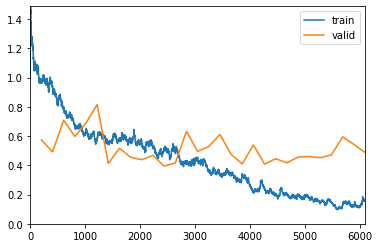

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.998362,0.614300,0.253333,0.746667,0.727222,00:17
1,0.919787,0.557243,0.173333,0.826667,0.770833,00:17
2,0.821192,0.507997,0.153333,0.846667,0.791945,00:17
3,0.589659,0.488046,0.200000,0.800000,0.765555,00:17
4,0.478292,0.477126,0.200000,0.800000,0.726111,00:17
5,0.460333,0.362019,0.140000,0.860000,0.866944,00:17
6,0.436004,0.429564,0.220000,0.780000,0.854167,00:17
7,0.438195,0.416113,0.166667,0.833333,0.835000,00:17
8,0.395416,0.397509,0.140000,0.860000,0.836111,00:17
9,0.379693,0.555660,0.186667,0.813333,0.784722,00:17


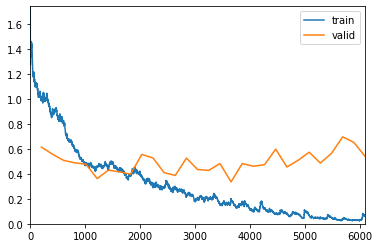

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.956202,0.674274,0.253333,0.746667,0.696667,00:16
1,0.888448,0.597661,0.240000,0.760000,0.709167,00:16
2,0.755254,0.520230,0.213333,0.786667,0.811389,00:16
3,0.562492,0.485357,0.193333,0.806667,0.779444,00:16
4,0.522826,0.367653,0.153333,0.846667,0.851111,00:16
5,0.519858,0.530685,0.266667,0.733333,0.741667,00:16
6,0.433063,0.399600,0.146667,0.853333,0.853889,00:16
7,0.457967,0.340887,0.126667,0.873333,0.877500,00:16
8,0.355134,0.439246,0.193333,0.806667,0.849167,00:16
9,0.347215,0.410822,0.186667,0.813333,0.853611,00:16


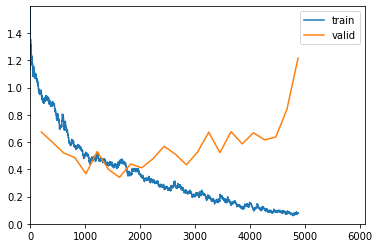

In [ ]:
seeds = [1,2,3,4,5,6,7,8,9,10]
epochs = 30

for seed in seeds:
    
    
    #Baseline
    metrics1 = train_variant(seed, epochs, lambda x: x)
    
    #Without SE
    metrics2 = train_variant(seed, epochs, remove_se_from_model)

    #Without SE and With ARL
    metrics3 = train_variant(seed, epochs, add_attn_geffnet_efficientnet_without_se)

    #With everything
    metrics4 = train_variant(seed, epochs, add_attn_geffnet_efficientnet)


    #write results
    write_results(seed, metrics1, metrics2, metrics3, metrics4)
    

# Analyze results

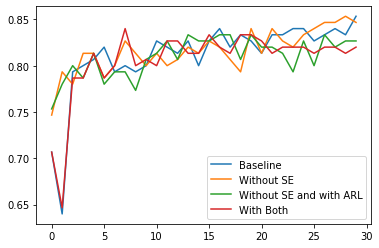

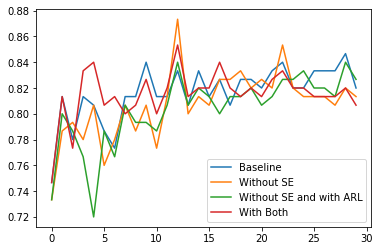

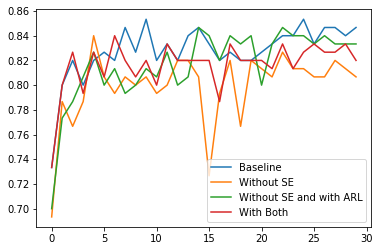

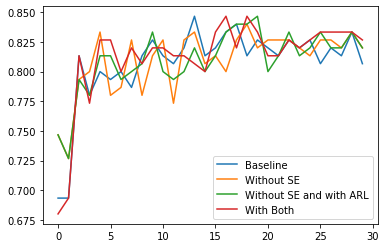

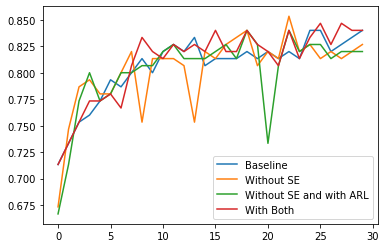

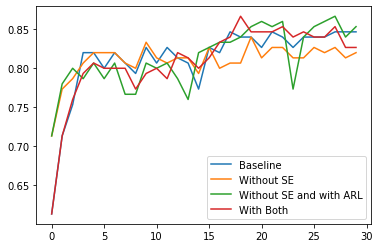

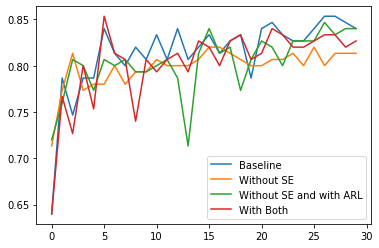

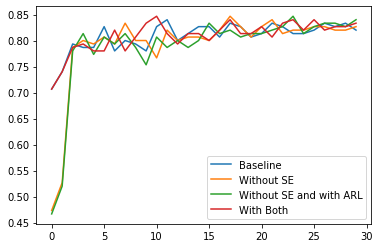

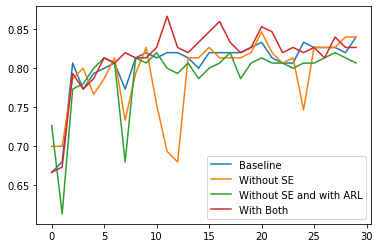

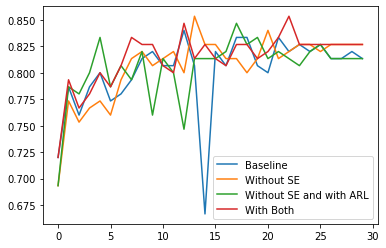

In [61]:
runs = {}
for i in range(1,11):
    runs[i] = pd.read_csv(f'{results_file_name}_{i}.txt')
#     runs[i] = pd.read_csv(f'fan_run_seed_{i}.txt')

    runs[i].plot()

In [82]:
series_runs = {col: [] for col in columns}

max_acc_for_each_run = [series_runs[col].append(runs[r].max()[col]) for col in columns for r in runs]


In [85]:
df = pd.DataFrame(series_runs)

In [86]:
df.describe()

,Baseline,Without SE,Without SE and with ARL,With Both
count,10.000000,10.000000,10.000000,10.000000
mean,0.846000,0.846667,0.843333,0.851333
std,0.005837,0.013699,0.011863,0.009454
min,0.840000,0.820000,0.820000,0.840000
25%,0.840000,0.840000,0.840000,0.846667
50%,0.846667,0.846667,0.846667,0.850000
75%,0.851667,0.853333,0.846667,0.853333
max,0.853333,0.873333,0.866667,0.866667
